## SENTIMENT ANALYSIS OF AMAZON CUSTOMER REVIEW USING PRE-TRAINED TRANSFORMER-BASED NLP MODEL

### Objectives of this test

- Implement the Hugging Face the **TFDistilBertForSequenceClassification** for **binary text classification** using transfer learning technique
- Implement the Hugging Face API for native TensorFlow
- Do a **model estimation** by computing the prediction probability for each class

## DATA PREPARATION


### I. Installing libraries and dependencies

In [1]:
# Importing framework for Natural Language Processing (NLP) model development
import tensorflow as tf

In [2]:
# Making sure a Graphics Processeing Unit (GPU) is available to be able to handle the computational requirements of a
# large-sized machine learning model
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print('Num GPUs Available: ', num_gpus_available)  # Note that the model will require the use of GPU
assert num_gpus_available > 0

Num GPUs Available:  1


In [ ]:
# Installing transformers
!pip3 install transformers

In [ ]:
# Installing version of pandas_ta and numpy v1.19.5 that are compatible with colab 
# and don't create conflicts when it comes to dependencies
! pip3 install pandas_ta==0.2.45b 

In [5]:
! pip3 install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Importing data analysis tools and modules for NLP tasks
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import pandas as pd
import numpy as np

In [ ]:
# Importing NLTK to be able to perform futher NLP tasks
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

### II. Importing data set, exploratory data analysis, and preprocessing

The dataset that I am using is the **amazon personal care appliances reviews** which is a subset of the large Amazon Product review. The dataset is already stored in the **TensorFlow database** and can be loaded directly using the ‘tfds‘ API from Tensorflow. 

The dataset consists of reviews of **Amazon Personal_Care_Appliances_v1_00 products in US marketplace**.

In [ ]:
import tensorflow_datasets as tfds
ds = tfds.load('amazon_us_reviews/Personal_Care_Appliances_v1_00', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

In [ ]:
# Converting dataset into a pandas data frame using ‘tfds.as_dataframe‘ API.
df = tfds.as_dataframe(ds)

In [ ]:
# Getting a glimpse of the data frame
df.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'13986323',0,b'US',b'Personal_Care_Appliances',b'B00847JQZ6',b'997683625',"b'SE - Reading Glass - Spring Loaded Hinges, 4...","b""These glasses are an excellent value. The f...",b'2015-01-04',b'These glasses are an excellent value. The fi...,b'R3VEUFVA9QJY55',4,0,0,1
1,b'50574716',3,b'US',b'Personal_Care_Appliances',b'B00N5HD340',b'955577225',b'Straight Razor',"b""Always wanted to try straight razor shaving ...",b'2015-08-05',b'A fantastic way to cheaply try straight razo...,b'R2DTQV5SMJ0CK7',5,3,0,1
2,b'50593972',0,b'US',b'Personal_Care_Appliances',b'B0077L1X24',b'120764066',b'Philips Sonicare Flexcare & Healthy White Pl...,b'I usually either throw my toothbrush in a pl...,b'2012-11-17',b'Great for travel',b'R3OJ06NK99WLNJ',4,0,0,1
3,b'18935813',0,b'US',b'Personal_Care_Appliances',b'B001CHCQ9I',b'830133534',b'Massage Table Sheet Set - Poly/cotton',b'Top quality.',b'2014-12-22',b'Five Stars',b'R3B4JKHR1KTI7J',5,0,0,1
4,b'48412788',1,b'US',b'Personal_Care_Appliances',b'B0016BJS2S',b'925685259',"b'TRIMEDICA, AlkaMax pH Plus Liquid - 1 oz'","b'Today I received 1 Fl. Oz, Natures Balance ...",b'2014-06-11',b'*Product sent not as shown',b'R3H50GB2FS0QPC',3,1,0,1


In [ ]:
# Getting the number of rows and columns
df.shape

(85981, 15)

In [ ]:
# Getting useful information about the data frame
# Note that the column containing the labels (i.e. 'star_rating') is integer in type
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 85981 entries, 0 to 85980
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   data/customer_id        85981 non-null  object
 1   data/helpful_votes      85981 non-null  int32 
 2   data/marketplace        85981 non-null  object
 3   data/product_category   85981 non-null  object
 4   data/product_id         85981 non-null  object
 5   data/product_parent     85981 non-null  object
 6   data/product_title      85981 non-null  object
 7   data/review_body        85981 non-null  object
 8   data/review_date        85981 non-null  object
 9   data/review_headline    85981 non-null  object
 10  data/review_id          85981 non-null  object
 11  data/star_rating        85981 non-null  int32 
 12  data/total_votes        85981 non-null  int32 
 13  data/verified_purchase  85981 non-null  int64 
 14  data/vine               8598

In [ ]:
# Getting statistical information about the data frame
# Based on the count, mean, and max values, the data frame contains data that is normalised more or less
df.describe()

,data/helpful_votes,data/star_rating,data/total_votes,data/verified_purchase,data/vine
count,85981.000000,85981.000000,85981.000000,85981.000000,85981.000000
mean,3.349484,3.977402,4.058990,0.263651,0.999628
std,19.483167,1.433130,20.825996,0.440615,0.019288
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000,1.000000
50%,0.000000,5.000000,1.000000,0.000000,1.000000
75%,2.000000,5.000000,3.000000,1.000000,1.000000
max,2785.000000,5.000000,2876.000000,1.000000,1.000000


In [ ]:
# Finding out the total number of instances of both positive and negative reviews
# From a range of 0-5, I will consider a positive rating as a value between 3-5, while 
# anything less than 3 is a negative rating
df['data/star_rating'].value_counts()

5    48897
4    13657
1    11036
3     7050
2     5341
Name: data/star_rating, dtype: int64

**BINARY CLASSIFICATION & IMPUTING 'SENTIMENT' AND 'SHORT_REVIEW' COLUMNS; ADDING 'WORD_COUNTS' FEATURE**

The **rating provided by the customer is on a scale of 1-5**( 5 being the highest). As I am going to implement a *binary classification model*, I shall be converting these ratings into 2 categories, i.e 1 and 0. **Ratings above and equal to 3 will be labeled as Positive(1)** and **below 3 will be negative(0)**. The following code will help us implement these steps.

In [ ]:
df['Sentiment'] = df['data/star_rating'].apply(lambda score: 'positive' if score >= 3 else 'negative')
df['Sentiment'] = df['Sentiment'].map({'positive':1, 'negative':0})

In [ ]:
df['short_review'] =df['data/review_body'].str.decode("utf-8")

In [ ]:
df = df[['short_review', 'Sentiment']]

In [ ]:
# Getting a glimpse of the new data frame
df.head()

,short_review,Sentiment
0,These glasses are an excellent value. The fit...,1
1,Always wanted to try straight razor shaving (a...,1
2,I usually either throw my toothbrush in a plas...,1
3,Top quality.,1
4,"Today I received 1 Fl. Oz, Natures Balance Al...",1


In [ ]:
# Adding another feature 'word_counts' to the data frame
df['word_counts'] = df['short_review'].apply(lambda x: len(str(x.split())))

In [ ]:
# Again taking a glance at the data frame
df.head()

,short_review,Sentiment,word_counts
0,These glasses are an excellent value. The fit...,1,465
1,Always wanted to try straight razor shaving (a...,1,1169
2,I usually either throw my toothbrush in a plas...,1,347
3,Top quality.,1,19
4,"Today I received 1 Fl. Oz, Natures Balance Al...",1,1211


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85981 entries, 0 to 85980
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   short_review  85981 non-null  object
 1   Sentiment     85981 non-null  int64 
 2   word_counts   85981 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.0+ MB


**PLOTTING AVERAGE NUMBER OF WORDS IN POSITIVE (1) AND NEGATIVE (0) REVIEWS**

Text(0.5, 1.0, 'Avg. no. of words in short_review vs. Sentiment')

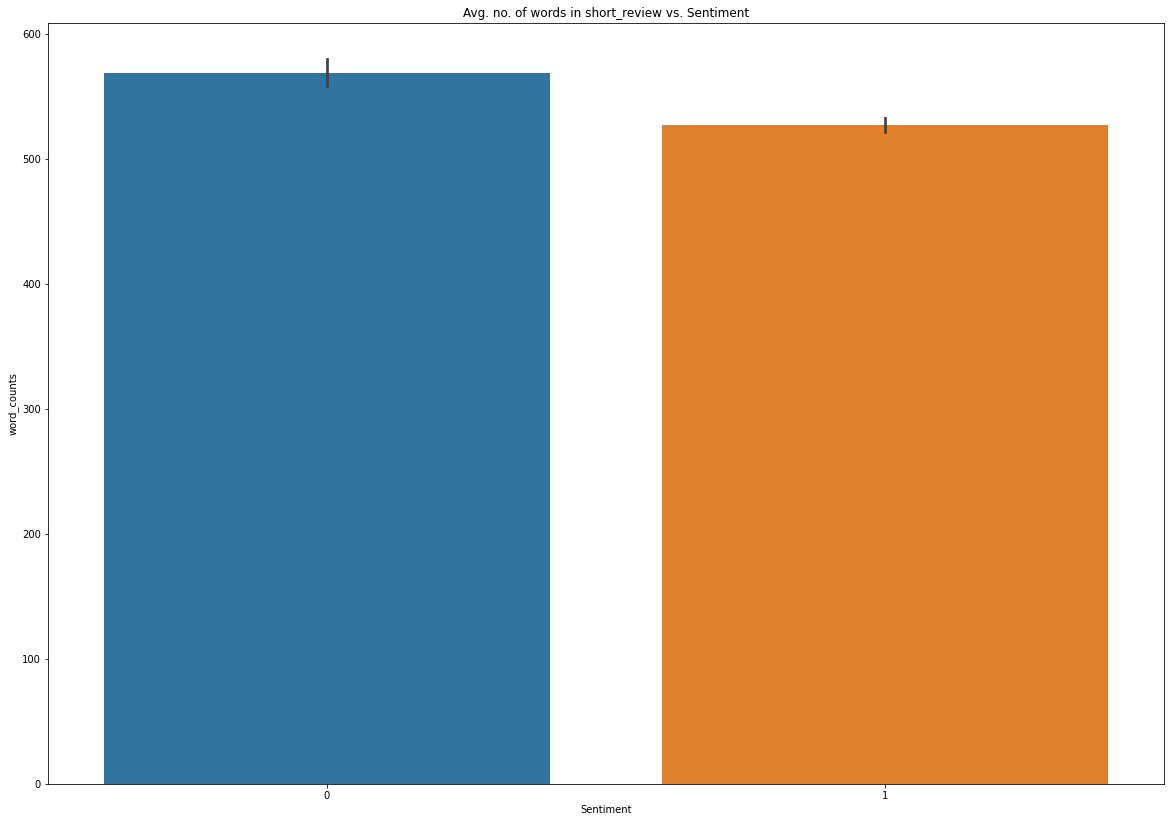

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,14))
sns.barplot(x='Sentiment', y='word_counts', data=df)
plt.title('Avg. no. of words in short_review vs. Sentiment')

**DISPLAYING NULL VALUES IF ANY IN ANY FEATURE**

In [ ]:
print(df.isna().sum()) 

short_review    0
Sentiment       0
word_counts     0
dtype: int64


**NOTE**:
It appears that the **positive reviews on average contain lesser number of words relative to negative reviews**. 

**Anticipating Implementation of a Pre-trained BERT NLP model**

The dataset consists of several columns ranging from Product ID to reviews, heading, and star rating provided by the customer. For this project, I am extracting mainly the **reviews** (ie feature column) and the **corresponding rating provided by the customer** (i.e. label column). Hence, I am dropping the other features/columns in this data frame. 

Since our chosen pre-trained model, BERT, requires a lot of computational power and a huge corpus of training data for model development, I am only going to focus on the said two columns of the data frame. 

### III. Data cleaning: Tokenization of text

There is a need *to convert the review column into numerical values* as machine learning models operate on numerical features. This is called **text vectorisation**. 

**METHOD**

In this application, I am going to use the **Tokenizer class from pre-trained DistilBert.**

In [ ]:
# Converting the feature column ('short_review') and label ('Sentiment') into a set of lists as that’s how our Tokenizer wants the data. 
reviews = df['short_review'].values.tolist()
labels = df['Sentiment'].tolist()

In [ ]:
#print(reviews[:2])
#print(labels[:2])

### IV. Splitting data into training and testing sets

The tokenizer needs to be fitted on the training set. To split the data into training and validation sets, we will make use of **Train-test-split class from Scikit-Learn**.

In [ ]:
from sklearn.model_selection import train_test_split
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.3)

In [5]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

In [ ]:
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=128)

The **Tensorflow API** provides a seemingly easy way to build data pipelines. Using 'from-Tensor-Slices', we can easily combine our features tokens and labels into a dataset.

In [ ]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

## MODEL TRAINING AND OPTIMISATION

In this application, I am going to use **TFDistilBertForSequenceClassification** for the sentiment analysis and put the **‘num-labels’ parameter equal to 2 as we are doing a binary classification**.

### V. Defining and loading the model

**FINE-TUNING WITH NATIVE TENSORFLOW**

I take an instance of the class **TFDistilBertForSequenceClassification** and point the model’s name as a parameter.

In [ ]:
# This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2.
# Making a model object
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english', num_labels=2 )

In [ ]:
# Using the Hugginface model saves the time and effort to build the model on one's own
# https://www.tensorflow.org/official_models/fine_tuning_bert_files/output_8L__-erBwLIQ_0.png?dcb_=0.04391390122987171
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


### VI. Training the model

There is no need to put additional layers; and using **a Hugging face transformer**, the model can now be trained with the following configuration:

**Epochs**: 5

**Batch size:** 16

**Learning rate (Adam):** 5e-5 (0.00005)

*If the number of epochs  increased, it will give rise to overfitting problems as well as take more time for the model to train*. 

In [ ]:
# I implement the 'tf.SparseCategoricalCrossentropy' loss function. 
# This also means that the labels are mutually exclusive for 
# each data, meaning each data entry can only belong to one class.
optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5) # Defining the loss function & setting the learning rate
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions 
model.compile(optimizer=optimizerr,   # Compiling a model                               
              loss=losss,
              metrics=['accuracy'])
history = model.fit(train_dataset.shuffle(100).batch(16),   # Running a model.fit() method for training
          epochs=5,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

Epoch 1/5
3762/3762 [==============================] - 3959s 1s/step - loss: 0.1922 - accuracy: 0.9206 - val_loss: 0.1874 - val_accuracy: 0.9180
Epoch 2/5
3762/3762 [==============================] - 3941s 1s/step - loss: 0.1295 - accuracy: 0.9507 - val_loss: 0.1710 - val_accuracy: 0.9319
Epoch 3/5
3762/3762 [==============================] - 3913s 1s/step - loss: 0.0847 - accuracy: 0.9682 - val_loss: 0.2082 - val_accuracy: 0.9273
Epoch 4/5
3762/3762 [==============================] - 3917s 1s/step - loss: 0.0588 - accuracy: 0.9789 - val_loss: 0.2631 - val_accuracy: 0.9212
Epoch 5/5
3762/3762 [==============================] - 3914s 1s/step - loss: 0.0447 - accuracy: 0.9844 - val_loss: 0.2956 - val_accuracy: 0.9258


*The complete model gets trained in around 1 hour/epoch for five(5) epochs, that’s why it is important to keep the number of epochs and batch size low.*

**In 5 epochs, the models give 98% and 92% accuracy on the Training and Validation sets, respectively. Once the model is trained, it can be saved then loaded later for model evaluation on unseen data. This can be done using ‘model.save’ API**.

**PLOT**

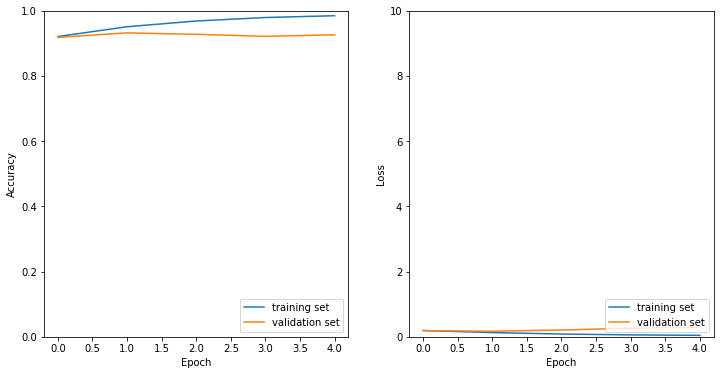

In [ ]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
%matplotlib inline

def plot_history(history : tf.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your 'fit' method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
    plt.show()

plot_history(history)

### VII. Saving the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save_pretrained('drive/MyDrive/tdb_sentiment')

In [ ]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained('drive/MyDrive/tdb_sentiment')

## EVALUATION


To evaluate the model accuracy on unseen data, the saved data can be loaded and **tested on new input (sentences) to see if the sentiment is predicted correctly or not**.

### VIII. Predicting results

In [11]:
# A 5-star rating from https://www.amazon.com/Philips-PrecisionPerfect-Precision-HP6390-51/dp/B00I471M9E/ref=lp_17395279011_1_8#customerReviews
test_review1 = '''    
I've been painfully plucking my chin hairs 
and lady moustache for years. This thing does 
wonders!! The blade is close enough to get a smooth 
shave, and it also has a protector so it doesn't cut your 
skin. Easy to use; MUCH faster than plucking; and less 
painful than waxing and plucking. Would definitely recommend!!
'''

predict_input = tokenizer.encode(test_review1,
                                 truncation=True,
                                 padding=True,
                                 return_tensors='tf')

tf_output = loaded_model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)  # Activation set to softmax for Sparse Categorical Entropy loss
labels = ['Negative','Positive']
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

Positive


In [12]:
# A 1-star rating from https://www.amazon.com/product-reviews/B00I471M9E/ref=acr_dp_hist_1?ie=UTF8&filterByStar=one_star&reviewerType=all_reviews#reviews-filter-bar
test_review2 = '''
This product lasted about 4 months - thought the battery was bad 
so I replaced it and it still didn’t work - it was dead ! I used it 
a total of 3 times !!! Had to toss , would not buy again ... I’m going 
back to my old school methods of using a scissor and a comb ...
'''
predict_input = tokenizer.encode(test_review2,
                                 truncation=True,
                                 padding=True,
                                 return_tensors='tf')

tf_output = loaded_model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)  # Activation set to softmax for Sparse Categorical Entropy loss
labels = ['Negative','Positive']
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

Negative


## CONCLUSION

**My re-trained transformer NLP model, a pre-trained DistilBERT, is a MVP** that analyses and predicts with remarkable accuracy between a positive and a negative customer review. 